In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

# Skip-gram Model
**通过嵌⼊层和批量矩阵乘法实现跳元模型。⾸先回顾嵌⼊层是如何⼯作的。**

#### 嵌⼊层

In [8]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


**嵌⼊层的输⼊是词元（词）的索引。对于任何词元索引i，其向量表⽰可以从嵌⼊层中的权重矩阵的第i⾏获得。由于向量维度（output_dim）被设置为4，因此当⼩批量词元索引的形状为（2，3）时，嵌⼊层返回具有形状（2，3，4）的向量。**

In [9]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.5741,  1.1767,  1.4030,  0.5083],
         [-0.8526, -0.3022,  0.9050, -1.0043],
         [-0.2211, -1.6987,  0.8607,  0.3517]],

        [[ 0.3876,  1.0377,  1.2490, -1.6812],
         [ 0.2618,  2.0092,  1.1038, -0.1332],
         [-0.6688, -0.0693, -0.9009,  0.4218]]], grad_fn=<EmbeddingBackward0>)

#### 定义前向传播
**在前向传播中，跳元语法模型的输⼊包括形状为（批量⼤⼩，1）的中⼼词索引center和形状为（批量⼤⼩，max_len）的上下⽂与噪声词索引contexts_and_negatives**

In [10]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

skip_gram sample

In [11]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

####  训练

**⼆元交叉熵损失**
根据负采样损失函数的定义，我们将使⽤⼆元交叉熵损失。

In [12]:
class SigmoidBCELoss(nn.Module):
    """带掩码的⼆元交叉熵损失"""

    def __int__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction='none')
        return out.mean(dim=1)


loss = SigmoidBCELoss()

**初始化模型参数**
我们定义了两个嵌⼊层，将词表中的所有单词分别作为中⼼词和上下⽂词使⽤。字向量维度embed_size被设置为100。


In [13]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

#### 定义训练阶段代码
**训练阶段代码实现定义如下。由于填充的存在，损失函数的计算与以前的训练函数略有不同。**

In [14]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])

    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_epochs - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f},'f'{metric[1] / timer.stop():.1f} token/sec on {str(device)}')

loss 0.367,1157652.5 token/sec on cuda:0


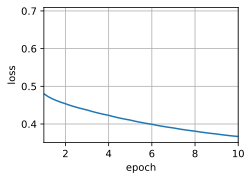

In [25]:
lr, num_epochs = 2e-3, 10
train(net, data_iter, lr, num_epochs)

####  应⽤词嵌⼊
**在训练word2vec模型之后，我们可以使⽤训练好模型中词向量的余弦相似度来从词表中找到与输⼊单词语义最相似的单词。**

In [16]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输⼊词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [24]:
get_similar_tokens('year',3, net[0])

cosine sim=0.598: compared
cosine sim=0.541: earlier
cosine sim=0.537: ton


In [21]:
print(vocab.token_to_idx)

{'<unk>': 0, 'the': 1, 'N': 2, 'of': 3, 'to': 4, 'a': 5, 'in': 6, 'and': 7, "'s": 8, 'that': 9, 'for': 10, '$': 11, 'is': 12, 'it': 13, 'said': 14, 'on': 15, 'by': 16, 'at': 17, 'as': 18, 'from': 19, 'million': 20, 'with': 21, 'mr.': 22, 'was': 23, 'be': 24, 'are': 25, 'its': 26, 'he': 27, 'but': 28, 'has': 29, 'an': 30, "n't": 31, 'will': 32, 'have': 33, 'new': 34, 'or': 35, 'company': 36, 'they': 37, 'this': 38, 'year': 39, 'which': 40, 'would': 41, 'about': 42, 'says': 43, 'more': 44, 'were': 45, 'market': 46, 'billion': 47, 'his': 48, 'had': 49, 'their': 50, 'up': 51, 'u.s.': 52, 'one': 53, 'than': 54, 'who': 55, 'some': 56, 'been': 57, 'also': 58, 'stock': 59, 'other': 60, 'share': 61, 'not': 62, 'we': 63, 'corp.': 64, 'if': 65, 'when': 66, 'i': 67, 'last': 68, 'president': 69, 'shares': 70, 'years': 71, 'all': 72, 'first': 73, 'two': 74, 'because': 75, 'trading': 76, 'after': 77, 'could': 78, 'inc.': 79, 'sales': 80, '&': 81, 'there': 82, 'out': 83, 'business': 84, 'only': 85, 'd